In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [64]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27

In [2]:
!pip install factor_analyzer  
from factor_analyzer import FactorAnalyzer, calculate_bartlett_sphericity, calculate_kmo

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#%cd drive/MyDrive/Github/master_thesis
%cd drive/MyDrive/GitHub/master-thesis
from clustering.utils import *

/content/drive/MyDrive/GitHub/master-thesis


In [5]:
def cronbach_alpha(df):
    # 1. Transform the df into a correlation matrix
    df_corr = df.corr()
    
    # 2.1 Calculate N
    # The number of variables equals the number of columns in the df
    N = df.shape[1]
    
    # 2.2 Calculate R
    # For this, we'll loop through the columns and append every
    # relevant correlation to an array calles "r_s". Then, we'll
    # calculate the mean of "r_s"
    rs = np.array([])
    for i, col in enumerate(df_corr.columns):
        sum_ = df_corr[col][i+1:].values
        rs = np.append(sum_, rs)
    mean_r = np.mean(rs)
    
   # 3. Use the formula to calculate Cronbach's Alpha 
    cronbach_alpha = (N * mean_r) / (1 + (N - 1) * mean_r)
    return cronbach_alpha

# Preprocessing

In [6]:
beh_cols = get_behaviour_cols()
df_fa_input = get_preprocessed_data(impute=True, impute_cols=beh_cols)

In [7]:
beh_cols

['Q1_1_feel_exposed',
 'Q1_2_covid_is_threat',
 'Q2_1_easy_to_follow_advice',
 'Q2_2_can_follow_advice_if_wanted',
 'Q2_3_if_follow_advice_safe',
 'Q2_4_if_follow_advice_others_safe',
 'Q2_5_follow_advice_relationships_impared',
 'Q2_6_follow_advice_life_degraded',
 'Q3_1_aware_hand_hygiene',
 'Q3_2_avoid_contact',
 'Q3_3_ensure_frequent_cleaning',
 'Q3_4_avoid_risk_groups',
 'Q3_5_keep_distance',
 'Q3_6_avoid_crowds',
 'Q3_7_minimize_activities_w_contact',
 'Q3b_1_sneeze_sleeve',
 'Q4_1_nr_contact_nonhouse_family',
 'Q4_2_nr_contact_colleagues',
 'Q4_3_nr_contact_friends',
 'Q4_4_nr_contact_strangers',
 'Q5_1_others_took_distance',
 'Q5_2_others_follow_advice',
 'Q5_3_others_not_care_spreading',
 'Q5_4_yourself_kept_distance',
 'Q5_5_feel_urge_scold',
 'Q6_1_sanctions_are_too_harsh',
 'Q6_2_advices_important',
 'Q6_3_others_can_avoid_spreading',
 'Q6_4_advices_create_fair_burden_dristribution',
 'Q6_5_ownership_of_advice',
 'Q6_6_clear_information_on_advice_reason',
 'Q6_7_advice_limi

In [8]:
scaler = MinMaxScaler()
fa_input = scaler.fit_transform(df_fa_input[beh_cols].to_numpy())
fa_input.shape

(118151, 34)

# Voraussetzungen prüfen
ref: Klaus Backhaus et al. Multivariate analysemethoden. Springer, 2021, pp. 413–488

First, Bartlett’s test (test for sphericity) tests the null hypothesis that the sample originates from
a population in which the variables are uncorrelated. Accordingly, the alternative hypothesis shows
that the variables are correlated. This must be shown for a factor analysis to be appropriate.

In [9]:
# P Value should be smaller 0.05
statistic, p_value = calculate_bartlett_sphericity(fa_input)
print(statistic, p_value)

1259639.5747444362 0.0


Second, the Kaiser-Meyer-Olkin (KMO) criterion, considers the bivariate partial correlations between all variables. This correlation describes the degree of dependence between two variables after excluding the influences of all other variables. The ideal value for a factor analysis is close to 1. In practice, values greater than 0.5 are considered sufficient; values greater than 0.8 are recommended.

In [10]:
#KMO should be greater or equal to 0.5
kmo_per_item, kmo_total = calculate_kmo(fa_input)
kmo_total

/usr/local/lib/python3.7/dist-packages/factor_analyzer/utils.py:249: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


0.903972908710264

In contrast, the Measure of Sampling Adequacy (MSA) as a third method assesses the suitability of individual variables for a factor analysis. This can also be determined with the help of the KMO. If individual variables have MSA values below 0.5, they can be excluded from the factor analysis.

In [11]:
kmo_per_item

array([0.79645448, 0.92093543, 0.90303503, 0.86390932, 0.92208718,
       0.88929548, 0.69802959, 0.77610222, 0.91668884, 0.94208921,
       0.92838833, 0.95841818, 0.94413475, 0.93354927, 0.91611283,
       0.92697916, 0.7367382 , 0.84446836, 0.79446218, 0.82431085,
       0.80610216, 0.80044302, 0.70378153, 0.93956008, 0.7997478 ,
       0.82038116, 0.93601628, 0.86980714, 0.94580925, 0.94835758,
       0.94327798, 0.77180354, 0.93299808, 0.92759874])

In [12]:
(kmo_per_item < 0.5).sum()

0

The fourth and last criterion is the anti-image covariance matrix. The anti-image represents the proportion of the variance that is independent of the other variables. Since factor analysis assumes that common factors are the basis of the variables, the variables are only suitable if they have a high common variance. Accordingly, the anti-image of the variables should be close to zero. As a rule of thumb, the data is suitable if less than 25\% of the non-diagonal elements of the matrix are different from zero.

In [61]:
# calc anti-image covariance matrix
R = np.corrcoef(fa_input, rowvar=False)
R_inv = np.linalg.inv(R)
temp = np.diagflat(R_inv.diagonal())
D = np.linalg.inv(temp)

In [62]:
anti_image_covariance_matrix = np.dot(np.dot(D, R_inv), D)

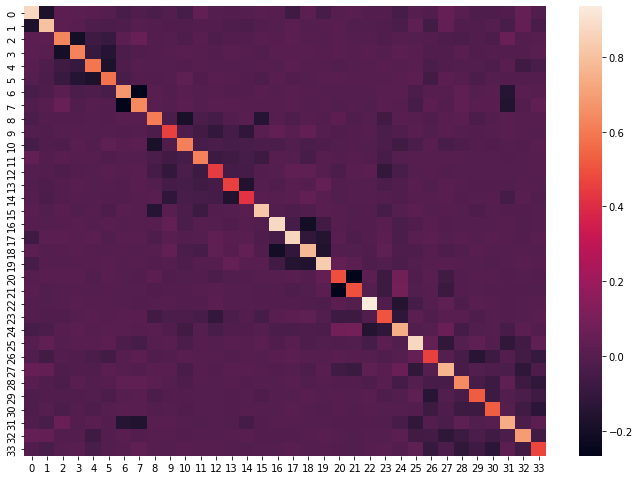

In [65]:
sns.heatmap(anti_image_covariance_matrix)

In [104]:
diff_zero_value = 0.05
num_non_diag_values_differ_from_zero = (anti_image_covariance_matrix > diff_zero_value).sum() + (anti_image_covariance_matrix < -diff_zero_value).sum() - anti_image_covariance_matrix.shape[0]
num_non_diag_values = anti_image_covariance_matrix.shape[0]**2 - - anti_image_covariance_matrix.shape[0]
percentage = num_non_diag_values_differ_from_zero / num_non_diag_values * 100
percentage

10.420168067226891

# Factor Analysis

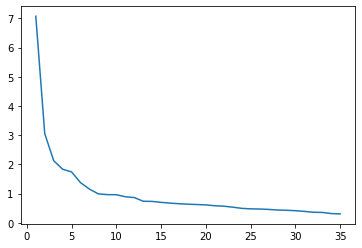

In [ ]:
fa = FactorAnalyzer()
fa.fit(fa_input)
#Get Eigen values and plot them
ev, v = fa.get_eigenvalues()
plt.plot(range(1,fa_input.shape[1]+1),ev)

In [ ]:
ev

array([7.07179448, 3.0526606 , 2.12605673, 1.83359402, 1.74142042,
       1.3745299 , 1.15257786, 0.98938474, 0.96449685, 0.96148078,
       0.89178278, 0.86489138, 0.73844637, 0.73277322, 0.69954529,
       0.67432625, 0.65304002, 0.63689961, 0.62556444, 0.6133253 ,
       0.58389428, 0.56855057, 0.53635413, 0.4944736 , 0.477601  ,
       0.47165949, 0.45849825, 0.43836304, 0.42845244, 0.41471446,
       0.39055627, 0.36201968, 0.35553351, 0.31640358, 0.30433467])

In [ ]:
num_factors_one = (ev > 1).sum()
num_factors_avg = (ev > ev.mean()).sum()
print(f'Es gibt {num_factors_one} Eigenwerte, die größer als eins sind und {num_factors_avg} Eigenwerte, die größer als der Durchschnitt sind.')

Es gibt 7 Eigenwerte, die größer als eins sind und 7 Eigenwerte, die größer als der Durchschnitt sind.


In [ ]:
fa = FactorAnalyzer(7, rotation='varimax')
fa.fit(fa_input)
loads = fa.loadings_
print(loads)

[[ 1.44407085e-01  7.38970464e-02 -3.39915661e-02 -5.50488717e-02
   7.50028436e-02  6.81735572e-02  7.93399756e-02  3.91917573e-01]
 [ 2.54911345e-01  1.99600908e-01  7.06144388e-02 -1.48514021e-02
   4.55268555e-02 -2.98903408e-02  4.17672597e-02  3.90522183e-01]
 [ 1.35713343e-01  2.23461998e-01  5.87989224e-01  2.59976170e-02
  -1.69505731e-01 -5.04963639e-02  5.04757619e-02 -7.19421342e-02]
 [ 5.48500915e-02  1.56315882e-01  6.95571521e-01  3.19067939e-02
   1.53896255e-03 -6.67385275e-02  4.10981658e-02 -3.34175844e-02]
 [ 9.92561023e-02  3.55510791e-01  5.74848613e-01  6.95335406e-02
  -7.16032482e-03 -6.52279537e-02  2.71829808e-02  9.35283013e-03]
 [ 6.49984016e-02  2.64896950e-01  6.70731913e-01  3.00142446e-02
   1.95239494e-02 -6.49108677e-02  2.47448987e-02  9.76856250e-02]
 [-4.16941382e-03 -8.53012348e-02  6.88947016e-02  2.46582827e-04
   6.76240770e-01 -3.22711504e-02 -2.39656929e-02  8.85938031e-02]
 [-8.10687478e-02 -1.79250439e-01 -5.27547119e-02 -4.18313838e-03
   

# Evaluate Factors

In [ ]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27

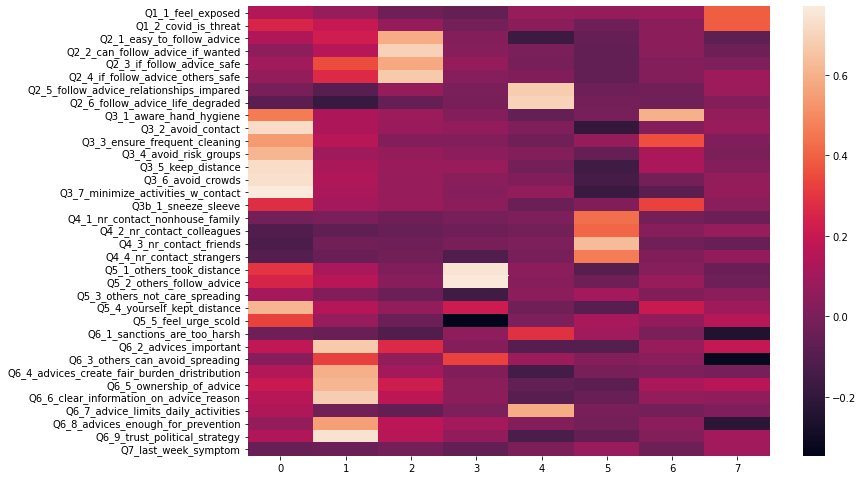

In [ ]:
heatmap_data = pd.DataFrame(loads.T, columns=beh_cols).T
sns.heatmap(heatmap_data)

In [ ]:
dict_fa = {}
for i in np.arange(7):
  col_names = heatmap_data[heatmap_data[i] > 0.4][i].index.tolist()
  df_factor = df_fa_input[col_names]
  factor_alpha = cronbach_alpha(df_factor)
  temp_dict = {'Factor_Names': col_names, 'Data': df_factor, 'Cronbach_Alpha': factor_alpha}
  print(f'Factor {i} with Columns {col_names} has a Cronbachs Alpha of {factor_alpha}')
  dict_fa.update({i: temp_dict})

Factor 0 with Columns ['Q3_1_aware_hand_hygiene', 'Q3_2_avoid_contact', 'Q3_3_ensure_frequent_cleaning', 'Q3_4_avoid_risk_groups', 'Q3_5_keep_distance', 'Q3_6_avoid_crowds', 'Q3_7_minimize_activities_w_contact', 'Q5_4_yourself_kept_distance'] has a Cronbachs Alpha of 0.8805374855633787
Factor 1 with Columns ['Q6_2_advices_important', 'Q6_4_advices_create_fair_burden_dristribution', 'Q6_5_ownership_of_advice', 'Q6_6_clear_information_on_advice_reason', 'Q6_8_advices_enough_for_prevention', 'Q6_9_trust_political_strategy'] has a Cronbachs Alpha of 0.8474830148581048
Factor 2 with Columns ['Q2_1_easy_to_follow_advice', 'Q2_2_can_follow_advice_if_wanted', 'Q2_3_if_follow_advice_safe', 'Q2_4_if_follow_advice_others_safe'] has a Cronbachs Alpha of 0.7825797188291914
Factor 3 with Columns ['Q2_5_follow_advice_relationships_impared', 'Q2_6_follow_advice_life_degraded', 'Q6_7_advice_limits_daily_activities'] has a Cronbachs Alpha of 0.6950313690985894
Factor 4 with Columns ['Q5_1_others_took_di

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Create new factors

In [ ]:
# latent_variable_names
new_variables = fa.transform(fa_input)
df_fa = pd.DataFrame(new_variables) # , columns=latent_variable_names
df_fa

,0,1,2,3,4,5
0,0.702708,0.736905,0.013848,0.595045,-0.506852,0.279142
1,0.891147,0.384225,0.472550,0.425550,0.341770,0.199452
2,0.519201,0.418916,0.691699,-0.416516,0.270534,-0.252001
3,0.915876,1.090491,-0.949254,-0.758631,0.150297,-0.038190
4,0.266998,0.412288,-2.031489,0.439282,0.922818,-0.349530
...,...,...,...,...,...,...
123225,0.709401,0.099010,-2.269721,0.180023,-0.144645,-0.039513
123226,0.407530,0.093222,0.684857,-0.654468,0.298144,-0.616601
123227,-0.811464,-0.190944,-0.183903,-0.072865,-1.000185,0.242839
123228,-0.202467,0.346022,-2.183940,-0.525703,0.286843,0.850911


In [ ]:
df_fa.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123230 entries, 0 to 123229
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       123230 non-null  float64
 1   1       123230 non-null  float64
 2   2       123230 non-null  float64
 3   3       123230 non-null  float64
dtypes: float64(4)
memory usage: 4.7 MB


# Plot Factors

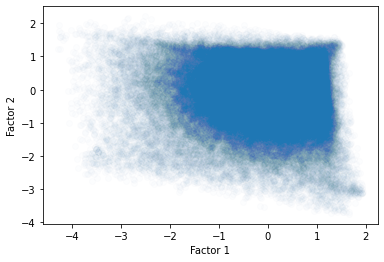

In [ ]:
plt.scatter(x=df_fa[0], y=df_fa[1], alpha=0.01)
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
plt.show()

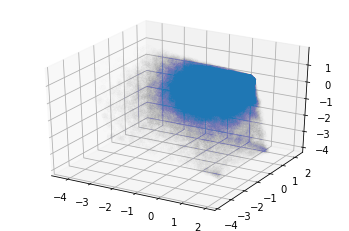

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(df_fa[0], df_fa[1], df_fa[2], alpha=0.005)

# Write Data

In [ ]:
df_fa_write = pd.concat([df_fa, df_fa_input], axis=1)
df_fa_write.dropna(subset=latent_variable_names, inplace=True)
df_fa_write.info()

In [ ]:
df_fa_write.to_csv('data/preprocessing/dim_reduction/220422_fa_data.csv', index=False)